# Import Libraries

In [ ]:
# Imprting libraries
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import time

# Data Preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/AIMS/Computer_Vision/Assignments/A2/Image_Denoising/lfwcrop_color.zip -d Dataset

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/lfwcrop_color/faces/Andre_Agassi_0022.ppm  
  inflating: Dataset/lfwcrop_color/faces/Kenneth_Bowersox_0001.ppm  
  inflating: Dataset/lfwcrop_color/faces/Hans_Blix_0012.ppm  
  inflating: Dataset/lfwcrop_color/faces/Boris_Trajkovski_0001.ppm  
  inflating: Dataset/lfwcrop_color/faces/Colin_Powell_0063.ppm  
  inflating: Dataset/lfwcrop_color/faces/Sergio_Garcia_0001.ppm  
  inflating: Dataset/lfwcrop_color/faces/Otto_Reich_0001.ppm  
  inflating: Dataset/lfwcrop_color/faces/Tony_Elias_0001.ppm  
  inflating: Dataset/lfwcrop_color/faces/Hosni_Mubarak_0004.ppm  
  inflating: Dataset/lfwcrop_color/faces/Misty_Dawn_Clymer_0001.ppm  
  inflating: Dataset/lfwcrop_color/faces/Heidi_Klum_0002.ppm  
  inflating: Dataset/lfwcrop_color/faces/Roh_Moo-hyun_0026.ppm  
  inflating: Dataset/lfwcrop_color/faces/Larry_Tanenbaum_0001.ppm  
  inflating: Dataset/lfwcrop_color/faces/Kate_Winslet_0004.ppm  
  inflating: Dataset/lfwcrop_c

We need to create a custom dataset class

In [ ]:
class NoiseImagesDataset(Dataset):
  def __init__(self, img_dir):
    self.img_dir = img_dir
    self.noisy_images = os.listdir(img_dir)

  def __len__(self):
    return len(self.noisy_images)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.noisy_images[idx])
    img = Image.open(img_path)
    img = np.array(img)
    # Normalizing the image
    img = (img - img.min()) / (img.max() - img.min())
    img = img.transpose((2, 0, 1))
    img = torch.tensor(img, dtype=torch.float32)
    # Adding a noise to the image
    noisy_img = img + torch.normal(0, 0.1 * img.max(), img.shape)
    noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())

    return noisy_img, img

In [ ]:
img_dir = "/content/Dataset/lfwcrop_color/faces"
dataset = NoiseImagesDataset(img_dir)

Text(0.5, 1.0, 'Noisy Image')

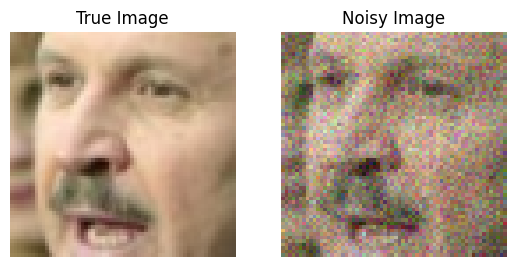

In [ ]:
# Looking at an example fo an image with its corresponding noisy image
x, y = dataset.__getitem__(0)
x = np.array(x).transpose((1, 2, 0))
y = np.array(y).transpose((1, 2, 0))
fig, axes = plt.subplots(1, 2)
axes[0].imshow(y)
axes[0].axis('off')
axes[0].set_title('True Image')
axes[1].imshow(x)
axes[1].axis('off')
axes[1].set_title('Noisy Image')

In [ ]:
# Dividing the dataset into 70% train set, 15% validation set and 15% test set
from torch.utils.data.sampler import SubsetRandomSampler

indices = list(range(len(dataset)))
np.random.shuffle(indices)
split1 = len(dataset) * 70 // 100
split2 = len(dataset) * 85 // 100
train_indices = indices[:split1]
val_indices = indices[split1:split2]
test_indices = indices[split2:]

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))


# Building the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Building the CNN Class:

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # Encoder
    self.conv1 = nn.Conv2d(3, 16, 5) # Output: 16 * 60 * 60
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # Output: 32 * 60 * 60
    self.pool = nn.MaxPool2d(2, 2)    # Output: 32 * 30 * 30

    self.conv3 = nn.Conv2d(32, 64, 5) # Output: 64 * 26 * 26
    self.conv4 = nn.Conv2d(64, 128, 3) # Output: 128 * 24 * 24
    self.pool = nn.MaxPool2d(2, 2)    # Output: 128 * 12 * 12

    # Decoder
    self.upSample1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2) # Output: 128 * 24 * 24
    self.transConv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1) # Output: 64 * 26 * 26
    self.transConv2 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1) # Output: 32 * 30 * 30

    self.upSample2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2) # Output: 32 * 60 * 60
    self.transConv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1) # Output: 16 * 60 * 60
    self.transConv4 = nn.ConvTranspose2d(16, 3, kernel_size=5, stride=1) # Output: 3 * 64 * 64

  def forward(self, x):
    # Encoding
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    saved_out = torch.clone(out) # 32 * 60 * 60
    out = self.pool(out)

    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))
    out = self.pool(out)

    # Decoding
    out = self.upSample1(out)
    out = self.transConv1(out)
    out = self.transConv2(out)

    out = self.upSample2(out) + saved_out # 32 * 60 * 60
    out = self.transConv3(out)
    out = self.transConv4(out) # 3 * 64 * 64

    return out


In [ ]:
learning_rate = 0.001
model = CNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [ ]:
def train(num_epochs, train_loader, val_loader, device):
    train_losses = []
    val_losses = []
    total_time = 0
    for epoch in range(num_epochs):
        tic = time.time()
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total += loss.item()

        train_loss = total / len(train_loader)
        train_losses.append(train_loss)

        # Calcuating the loss for the validation set
        total = 0
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total += loss.item()

        val_loss = total / len(val_loader)
        val_losses.append(val_loss)

        toc = time.time()
        total_time += toc - tic
        print('Epoch:', epoch + 1, '/', num_epochs, '\tDuration:', round((toc - tic), 2), 'secs', '\tTrain Loss:', round(train_loss, 4), '\tVal Loss:', round(val_loss, 4))

        toc = time.time()

    print('\nTotal Running time:', round((total_time) / 60, 2), 'mins')
    return train_losses, val_losses


# Starting training..
train_losses, val_losses = train(num_epochs=50, train_loader=train_loader, val_loader=val_loader, device=device)

Epoch: 1 / 50 	Duration: 13.05 secs 	Train Loss: 0.033 	Val Loss: 0.0082
Epoch: 2 / 50 	Duration: 12.76 secs 	Train Loss: 0.0071 	Val Loss: 0.0071
Epoch: 3 / 50 	Duration: 12.74 secs 	Train Loss: 0.0058 	Val Loss: 0.0053
Epoch: 4 / 50 	Duration: 12.74 secs 	Train Loss: 0.0049 	Val Loss: 0.0054
Epoch: 5 / 50 	Duration: 12.95 secs 	Train Loss: 0.0045 	Val Loss: 0.0041
Epoch: 6 / 50 	Duration: 12.76 secs 	Train Loss: 0.0042 	Val Loss: 0.0047
Epoch: 7 / 50 	Duration: 13.45 secs 	Train Loss: 0.0041 	Val Loss: 0.0037
Epoch: 8 / 50 	Duration: 13.07 secs 	Train Loss: 0.0037 	Val Loss: 0.0035
Epoch: 9 / 50 	Duration: 12.91 secs 	Train Loss: 0.0039 	Val Loss: 0.0046
Epoch: 10 / 50 	Duration: 12.84 secs 	Train Loss: 0.0035 	Val Loss: 0.0031
Epoch: 11 / 50 	Duration: 12.81 secs 	Train Loss: 0.0034 	Val Loss: 0.0032
Epoch: 12 / 50 	Duration: 13.07 secs 	Train Loss: 0.0032 	Val Loss: 0.004
Epoch: 13 / 50 	Duration: 13.48 secs 	Train Loss: 0.0033 	Val Loss: 0.0031
Epoch: 14 / 50 	Duration: 13.82 secs

# Results

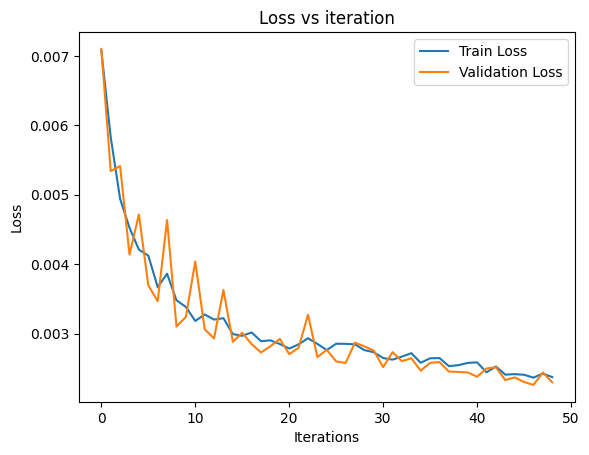

In [ ]:
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs iteration')
plt.legend()

In [ ]:
# TEST Loss
total = 0
for i, (inputs, labels) in enumerate(test_loader):
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  total += loss.item()

test_loss = total / len(test_loader)

print(f'Average Loss on the test images: {test_loss:.4f} ')

Average Loss on the test images: 0.0023 


Looking at some predictions examples of the model:

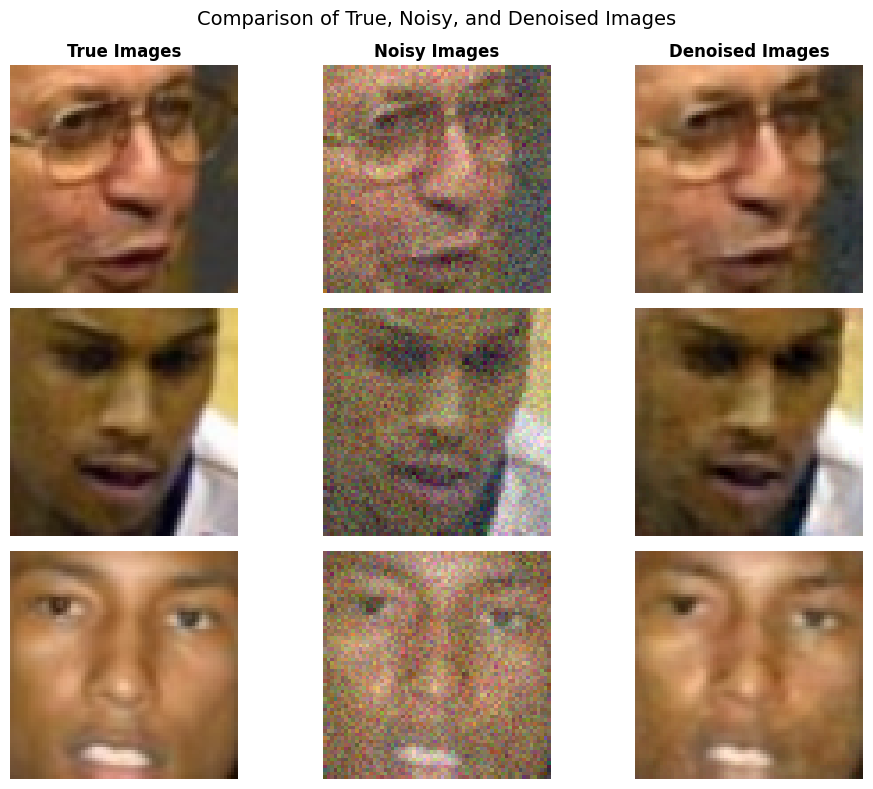

In [ ]:
with torch.no_grad():

    fig, axes = plt.subplots(3, 3, figsize=(10, 8))

    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        true = np.array(labels[0].to('cpu'))
        noisy = np.array(inputs[0].to('cpu'))
        denoised = outputs[0].to('cpu')
        denoised = denoised.detach().numpy()
        noisy = noisy.transpose(1, 2, 0)
        true = true.transpose(1, 2, 0)
        denoised = denoised.transpose(1, 2, 0)


        axes[i, 0].imshow(true, cmap='gray')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy, cmap='gray')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(denoised, cmap='gray')
        axes[i, 2].axis('off')

        if i == 0:
            axes[i, 0].set_title('True Images', fontsize=12, weight='bold')
            axes[i, 1].set_title('Noisy Images', fontsize=12, weight='bold')
            axes[i, 2].set_title('Denoised Images', fontsize=12, weight='bold')

        if i == 2:
            break


plt.suptitle("Comparison of True, Noisy, and Denoised Images", fontsize=14)

plt.tight_layout()

plt.show()